# Plot a comet lightcurve from `sssource`

References:
  Table definitions are in the [Data Products Definition Document](https://ls.st/dpdd) ... but at the time of the SSSC Sprint 2022, the simulated data products were not fully filled out.

In [1]:
import psycopg2 as pg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from astropy.time import Time
import astropy.units as u
from sbpy.activity import Afrho
from sbpy.data import Ephem

In [2]:
pwd = open("/home/shared/sssc-db-pass.txt").read()
con = pg.connect(database="lsst_solsys", user="sssc", password=pwd, host="epyc.astro.washington.edu", port="5432")

In [3]:
# define what orbit constitutes a cometary orbit
comet_params = {'T_J_max': 2.95,  # Tisserand no larger than this
                'e_min': 0.98}    # Eccentricity no smaller than this

In [4]:
# find a "comet"
df = pd.read_sql(
    """SELECT * FROM mpcorb
       INNER JOIN ssobjects ON (ssobjects.ssobjectid = mpcorb.ssobjectid)
       WHERE mpcorb.e > %(e_min)s
          OR (5.204 / (mpcorb.q / (1 - mpcorb.e)) + 2 * COS(RADIANS(mpcorb.incl)) * SQRT((mpcorb.q / (1 - mpcorb.e)) / 5.204 * (1 - mpcorb.e * mpcorb.e))) < %(T_J_max)s
       LIMIT 1""",
    con,
    params=comet_params)
comet = df.iloc[0]  # get first row of result
comet

/opt/conda/envs/rubin-sims-v0.9.0/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


mpcdesignation           S0000002a       
mpcnumber                               0
ssobjectid            8447890486452875146
mpch                               10.818
mpcg                                 0.15
                             ...         
yndata                                121
maxextendedness                       0.0
minextendedness                       0.0
medianextendedness                    0.0
flags                                   0
Name: 0, Length: 82, dtype: object

In [5]:
# get the photometry:
#   select all columns in sssources
#   combine columns from diasources where diasourceid matches
#   but limit results to the ssobjectid of our comet
phot = pd.read_sql(
    """SELECT * FROM sssources
       INNER JOIN diasources ON (sssources.diasourceid = diasources.diasourceid)
       WHERE sssources.ssobjectid=%(ssobjectid)s""",
    con, params=comet.to_dict()
)
phot

/opt/conda/envs/rubin-sims-v0.9.0/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,ssobjectid,diasourceid,mpcuniqueid,eclipticlambda,eclipticbeta,galacticl,galacticb,phaseangle,heliocentricdist,topocentricdist,...,declsigma,ra_decl_cov,snr,filter,mag,magsigma,_v,_magtrue,_ratrue,_dectrue
0,8447890486452875146,6587841883066085399,0,356.851153,-9.107452,87.580395,-69.084319,14.546751,3.807186,4.020755,...,0.000002,0.0,285.768900,z,17.260214,0.003793,17.560200,17.262200,0.767115,-9.601787
1,8447890486452875146,-7159109279155723609,0,59.308329,-20.952154,191.588482,-36.273875,4.187695,5.123790,4.197462,...,0.000002,0.0,216.541660,y,17.558233,0.005002,17.857492,17.554491,61.530780,-0.494978
2,8447890486452875146,-4873256491932764747,0,59.311096,-20.952397,191.589976,-36.271576,4.186626,5.123845,4.197483,...,0.000002,0.0,195.382460,y,17.549963,0.005543,17.857466,17.554466,61.533365,-0.494686
3,8447890486452875146,1305559744654628332,0,60.777308,-21.022067,192.309727,-35.031886,3.955013,5.153281,4.219282,...,0.000002,0.0,540.058200,g,18.168968,0.002009,17.868053,18.170053,62.888899,-0.291068
4,8447890486452875146,8397385236521954431,0,60.780459,-21.022114,192.311149,-35.029184,3.955291,5.153343,4.219349,...,0.000002,0.0,135.950940,u,19.484653,0.007957,17.868130,19.482130,62.891785,-0.290542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
554,8447890486452875146,-8365500290426860658,0,34.527426,-19.093226,175.458082,-56.962581,8.344400,6.276025,5.771223,...,0.000003,0.0,69.733864,y,18.868198,0.015459,19.190887,18.887888,38.601893,-4.994305
555,8447890486452875146,1801058191567595533,0,34.570614,-19.042110,175.406049,-56.903650,8.413429,6.275298,5.784518,...,0.000002,0.0,85.718470,y,18.874094,0.012593,19.198600,18.895601,38.623722,-4.932613
556,8447890486452875146,-5207186459605150284,0,39.135911,-21.091318,181.754242,-53.806591,5.196970,6.077328,5.233632,...,0.000003,0.0,68.407200,u,20.357357,0.015757,18.761307,20.375305,43.361119,-5.504170
557,8447890486452875146,-1561380110165288203,0,38.500882,-20.928133,181.115598,-54.293918,5.775282,6.069448,5.264884,...,0.000002,0.0,354.167180,r,18.627779,0.003061,18.800613,18.628614,42.744100,-5.533677


In [6]:
# package ephemeris information into an sbpy object
eph = Ephem.from_dict({'rh': phot['heliocentricdist'].values * u.au,
                       'delta': phot['topocentricdist'].values * u.au,
                       'phase': phot['phaseangle'].values * u.deg})

# simulated diasources do not have aperture information, but we use this for now:
aper = 2 * u.arcsec

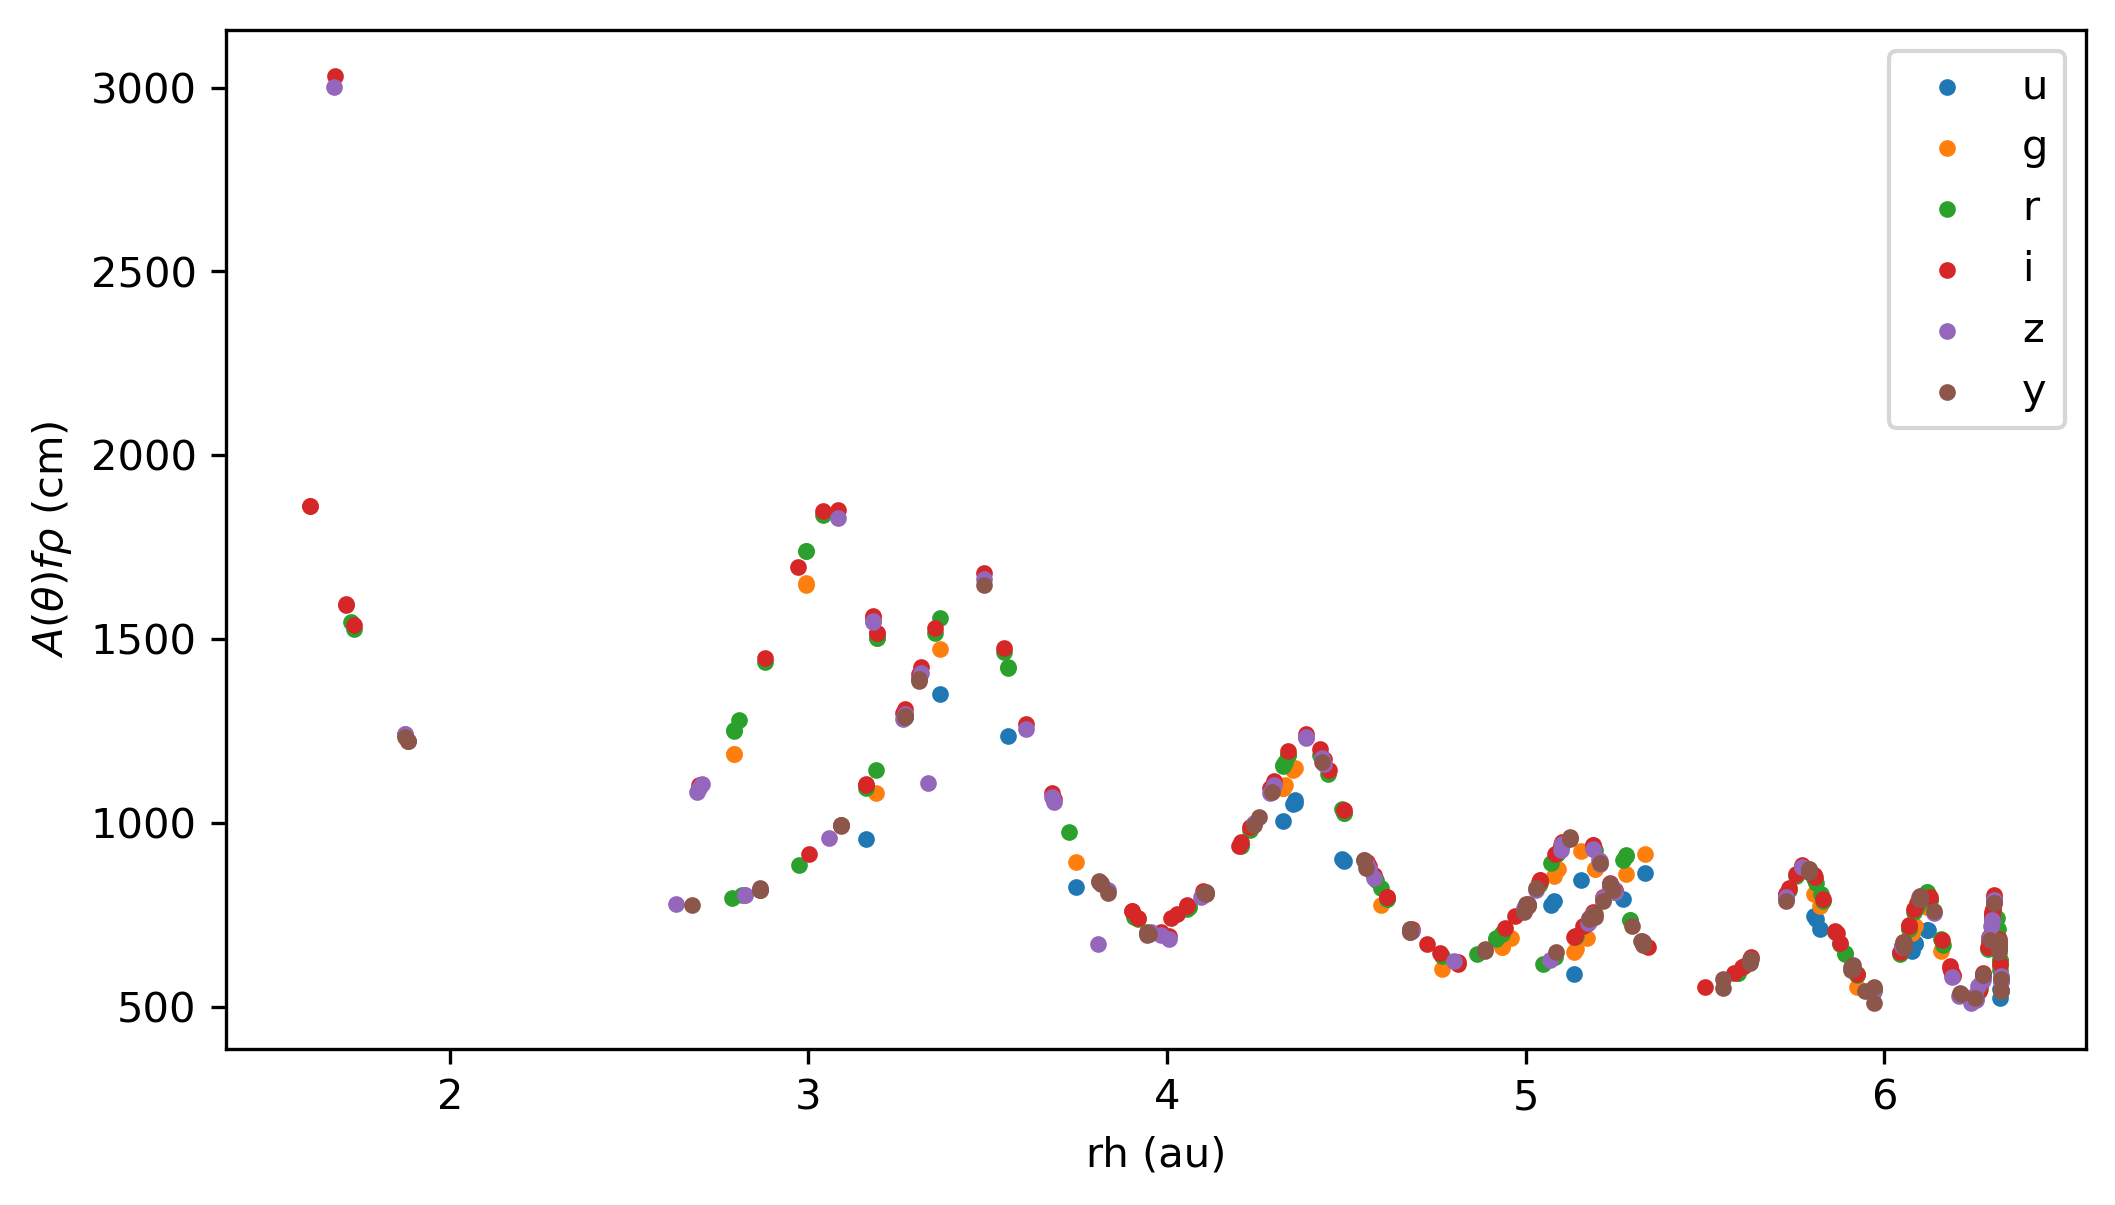

In [7]:
fig = plt.figure(1, (8, 4.5), dpi=300)
ax = fig.add_subplot(111)

for filt in 'ugrizy':
    i = phot['filter'].values == filt
    afrho = Afrho.from_fluxd(f'LSST {filt}', phot['mag'][i].values * u.ABmag, aper, eph[i])
    ax.scatter(phot['heliocentricdist'][i], afrho, marker='.', label=filt)

plt.setp(ax, xlabel='rh (au)', ylabel=r'$A(\theta)f\rho$ (cm)')
plt.legend()
plt.show()